In [1]:
import os
import jax
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import diffrax as dfx
import optax
import numpy as np 
import matplotlib.pyplot as plt
import optuna
from chainconsumer import Chain, ChainConsumer

from configs import make_dirs
from configs.shear import shear
from data.shear import get_shear_experiment, get_experiment_data

from sbiax.utils import make_df
from sbiax.ndes import Ensemble, CNF, Scaler
from sbiax.train import train_ensemble
from sbiax.compression.linear import mle
from sbiax.inference import nuts_sample
from sbiax.meta import get_trial_hyperparameters

This notebook shows you how to optimise the hyperparameters for the architecture and training of a normalising flow model.

We run density-estimation SBI on a datavector made up of cosmic shear two-point functions.

Our `config` object contains all the properties of the models, training and sampling. You could use all its properties without the `config` object itself.

In [3]:
config = shear()

key = jr.key(config.seed)
key, model_key, train_key, sample_key = jr.split(key, 4)

In [4]:
results_dir = "results/{}/{}/{}/".format(
    config.sbi_type, config.exp_name, config.seed
) 
make_dirs(results_dir)

RESULTS_DIR:
 results/nle/shear/0/


Here we sample a set of $n_s$ simulations from the true data likelihood $\mathcal{G}[\hat{\xi}|\xi[\pi], \Sigma]$ for training the normalising flow models.

In [5]:
(
    alpha,                  # True parameters
    parameter_names,        # Parameter names
    mu,                     # Model expectation
    covariance,             # Data covariance
    precision,              # Inverse data covariance
    dmu,                    # Theory derivatives
    F,                      # Fisher information
    Finv,                   # Inverse Fisher information 
    lower,                  # Lower prior bounds
    upper                   # Upper prior bounds
) = get_shear_experiment()

(
    X, 
    Y, 
    *_, # Estimated Fisher, covariance and precision (not used here)
    parameter_prior
) = get_experiment_data(
    key=key,
    true_covariance=True,
    n_sims=config.n_s,
    results_dir=results_dir
)

In this experiment we will use a linear compression parameterised by the true data covariance $\Sigma$.

It is common in practice to use an estimate of the covariance from a finite set of simulations.

Our compression is written as 

$$\hat{\pi} = \pi + F_{\Sigma}^{-1}E\Sigma^{-1}(\hat{\xi} - \xi[\pi])$$ 

where 
* $F_{\Sigma}^{-1}$ is the Fisher information matrix, 
* $\xi[\pi]$ is our model for the expectation,
* $E$ is some matrix defining this model $\xi[\pi]=\xi[\pi^0] + (\pi - \pi^0)^TE$ which depends on a fiducial parameter set $\pi^0$.

Note that this implicitly assumes the model $\xi[\pi]$ is known and is perfectly accurate.

In [6]:
def s(xi, pi):
    pi_ = mle(xi,
        pi=pi,
        Finv=Finv, 
        mu=mu + jnp.dot(pi - alpha, dmu), 
        dmu=dmu, 
        precision=precision
    )
    return pi_

Here we re-write the same function found in `sbiax.meta` for this example - to show how to define hyperparameters for a given type of model.


The parameters are held in a dictionary with key access, and exactly which parameters are used depends on the model (see `sbiax.meta`).

In [7]:
def get_trial_hyperparameters(trial, model_type):
    """ Arrange hyperparameters to optimise for and return to the experiment. """
    # Architecture
    if model_type == "CNF":
        model_hyperparameters = {
            "width" : trial.suggest_int(name="width", low=2, high=5, step=1), # NN width
            "depth" : trial.suggest_int(name="depth", low=0, high=2, step=1), # NN depth
            "dt" : trial.suggest_float(name="dt", low=0.01, high=0.15, step=0.01), # ODE solver timestep
            "solver" : trial.suggest_categorical(name="solver", choices=["Euler", "Heun", "Tsit5"]), # ODE solver
        }
    # Training
    training_hyperparameters = {
        "n_batch" : trial.suggest_int(name="n_batch", low=40, high=100, step=10), 
        "lr" : trial.suggest_float(name="lr", low=1e-5, high=1e-3, log=True), 
        "p" : trial.suggest_int(name="p", low=10, high=100, step=10),
    }
    return {**model_hyperparameters, **training_hyperparameters} 

Here we define the objective function - that takes in our training and architecture parameters - we need to optimise. 

The objective builds one density-estimating normalising flow, trains it, and calculates the validation loss. This loss is what `optuna` seeks to minimise.

We'll use a continuous normalising flow and put it in an `Ensemble` none the less. This object can pass through `jit` boundaries and has its own `log_prob` functions.

In [8]:
def objective(trial, params=None):
    # Objective to minimise; the fitting of a neural density estimator
    show_tqdm = params is not None

    scaler = Scaler(X, Y, use_scaling=config.model.use_scaling)

    if trial is not None:
        params = get_trial_hyperparameters(trial, model_type="CNF")

    solver = getattr(dfx, params["solver"])()

    # Build neural density estimators
    ndes = [
        CNF(
            event_dim=alpha.size, 
            context_dim=alpha.size, 
            width_size=2 ** params["width"],
            depth=params["depth"], 
            solver=solver,
            activation=config.model.activation,
            dt=params["dt"], 
            t1=config.model.t1, 
            exact_log_prob=config.model.exact_log_prob,
            scaler=scaler,
            key=model_key
        )
    ]

    ensemble = Ensemble(ndes, sbi_type=config.sbi_type)

    opt = optax.adamw(params["lr"])

    ensemble, stats = train_ensemble(
        train_key, 
        ensemble,
        train_mode=config.sbi_type,
        train_data=[X, Y], 
        opt=opt,
        n_batch=params["n_batch"],
        patience=params["p"],
        n_epochs=config.n_epochs,
        trial=trial,
        show_tqdm=show_tqdm,
        results_dir=results_dir
    )

    if trial is not None:
        return stats[0]["all_valid_loss"] # Loss on validation data
    else:
        return ensemble

Now we create a `storage` and `study` object which tracks the experiments run so far as well as the best hyperparameters at each point in the optimisation.

You'll see the trial progression with the validation losses, parameters that were used, and the best trial so far.

In [9]:
storage = optuna.storages.JournalStorage(
    optuna.storages.journal.JournalFileBackend(
        os.path.join(results_dir, "hyperparameter_opt_shear.log")
    )
)

study = optuna.create_study(
    study_name="hyperparameter_opt_shear",
    direction="minimize", # Minimise negative log-likelihood
    storage=storage,
    sampler=optuna.samplers.TPESampler(n_startup_trials=1)
) 

study.optimize(objective, n_trials=5)

df = study.trials_dataframe()
df.to_pickle(os.path.join(results_dir, "hyperparameter_opt_shear_df.pkl")) 

[I 2024-10-27 14:02:49,179] A new study created in Journal with name: hyperparameter_opt_shear


NDE has n_params=314.


[I 2024-10-27 14:04:55,657] Trial 0 finished with value: -8.275923728942871 and parameters: {'width': 3, 'depth': 2, 'dt': 0.11, 'solver': 'Heun', 'n_batch': 90, 'lr': 0.0009401192778704725, 'p': 80}. Best is trial 0 with value: -8.275923728942871.


Weights: [1.]
NDE has n_params=314.


[I 2024-10-27 14:06:53,257] Trial 1 finished with value: -8.723973274230957 and parameters: {'width': 3, 'depth': 2, 'dt': 0.11, 'solver': 'Heun', 'n_batch': 90, 'lr': 0.000947284281833248, 'p': 80}. Best is trial 1 with value: -8.723973274230957.


Weights: [1.]
NDE has n_params=714.


[I 2024-10-27 14:11:17,476] Trial 2 finished with value: -9.914827346801758 and parameters: {'width': 4, 'depth': 2, 'dt': 0.06999999999999999, 'solver': 'Euler', 'n_batch': 70, 'lr': 2.1745571657920497e-05, 'p': 70}. Best is trial 2 with value: -9.914827346801758.


Weights: [1.]
NDE has n_params=51.


[I 2024-10-27 14:27:36,042] Trial 3 finished with value: -3.6317970752716064 and parameters: {'width': 5, 'depth': 0, 'dt': 0.01, 'solver': 'Euler', 'n_batch': 40, 'lr': 1.1782780708681729e-05, 'p': 20}. Best is trial 2 with value: -9.914827346801758.


Weights: [1.]
NDE has n_params=554.


[I 2024-10-27 14:33:26,554] Trial 4 finished with value: -9.751214027404785 and parameters: {'width': 5, 'depth': 1, 'dt': 0.04, 'solver': 'Euler', 'n_batch': 60, 'lr': 1.9773967181349863e-05, 'p': 40}. Best is trial 2 with value: -9.914827346801758.


Weights: [1.]


Let's grab the best parameters from the study... 

In [10]:
print("Number of finished trials: {}".format(len(study.trials)))

trial = study.best_trial

print("Best trial\n>Value: {}".format(trial.value))
print(">Number: {}".format(trial.number))
for key, value in trial.params.items():
    print("\t{} : {}".format(key, value))

Number of finished trials: 5
>Value: -9.914827346801758
>Number: 2
	width : 4
	depth : 2
	dt : 0.06999999999999999
	solver : Euler
	n_batch : 70
	lr : 2.1745571657920497e-05
	p : 70


...and run the objective, returning the trained ensemble

In [11]:
ensemble = objective(trial=None, params=trial.params)

NDE has n_params=714.


Training:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Weights: [1.]


Now we sample a measurement to condition our posterior with. This noisy datavector is from the same likelihood above, and we pass it to the `Ensemble` likelihood function.

This `log_prob` function is sampled via the `nuts_sample` function below.

In [12]:
# Get a noisy datavector with different alpha parameters
key_data, key_state, key_sample = jr.split(sample_key, 3)

# Generates datavector d ~ G[d|xi[pi], Sigma]
datavector = jr.multivariate_normal(key_data, mu, covariance)

# Linear summary
X_ = s(datavector, alpha)

ensemble = eqx.nn.inference_mode(ensemble)

log_prob_fn = ensemble.ensemble_log_prob_fn(X_, parameter_prior)

In [17]:
n_chains = 1

samples, samples_log_prob = nuts_sample(
    key_sample, log_prob_fn, n_chains=n_chains, prior=parameter_prior
)

Finally we plot the posterior. Nothing fancy here, we simply use `chainconsumer` to plot our chains. 

The `Ensemble` likelihood chain is compared to a Fisher forecast - which is the analytic solution to this inference problem given the Gaussian errors and linear model.

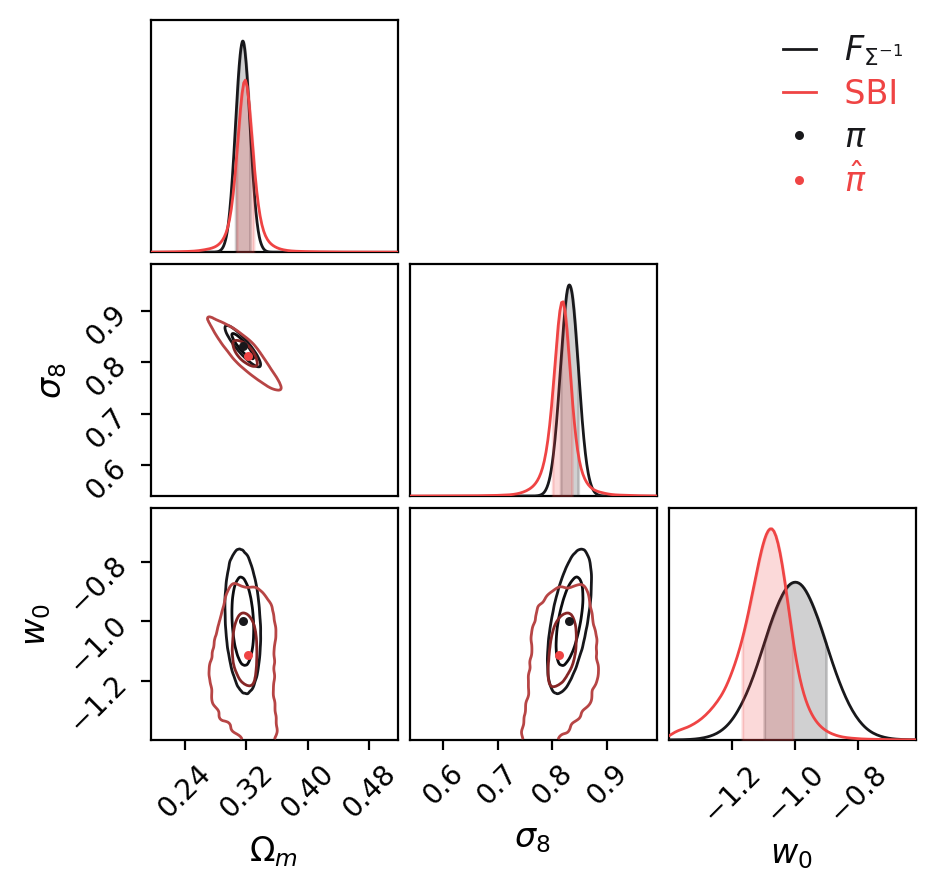

In [18]:
c = ChainConsumer()

c.add_chain(
    Chain.from_covariance(
        alpha,
        Finv,
        columns=parameter_names,
        name=r"$F_{\Sigma^{-1}}$",
        color="k",
        shade_alpha=0.
    )
)
for n in range(n_chains):
    c.add_chain(
        Chain(
            samples=make_df(samples[n], samples_log_prob[n], parameter_names), 
            name="SBI", 
            color="r", 
            shade_alpha=0.
        )
    )
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(alpha))), name=r"$\pi$", color="k"
)
c.add_marker(
    location=dict(zip(parameter_names, np.asarray(X_))), name=r"$\hat{\pi}$", color="r"
)

fig = c.plotter.plot()
fig.set_dpi(200)
fig.set_figheight(4.5)
fig.set_figwidth(4.5)
plt.show()

You can see the model - obtained with a somewhat small validation set and an unrealistically short hyperparameter optimisation procedure - gives a posterior which could easily be improved upon when comparing the red and black contours. 

This would need to be run for longer, with more validation simulations.